In [1]:
import os
import time
import pickle
import numpy as np

import torch
from torch import nn
from accelerate import Accelerator

import util as U
from spender import SpectrumAutoencoder
from spender.data import desi

from collections import OrderedDict

/Users/ng27753/Astronomy_Research/spender/.venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/ng27753/Astronomy_Research/spender/.venv/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# --- plotting --- 
import corner as DFM
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rcParams['text.usetex'] = True
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['axes.linewidth'] = 1.5
mpl.rcParams['axes.xmargin'] = 1
mpl.rcParams['xtick.labelsize'] = 'x-large'
mpl.rcParams['xtick.major.size'] = 5
mpl.rcParams['xtick.major.width'] = 1.5
mpl.rcParams['ytick.labelsize'] = 'x-large'
mpl.rcParams['ytick.major.size'] = 5
mpl.rcParams['ytick.major.width'] = 1.5
mpl.rcParams['legend.frameon'] = False

In [3]:
print("torch.cuda.device_count():",torch.cuda.device_count())


torch.cuda.device_count(): 0


In [4]:
niter = 0


In [5]:
def load_model(filename, models, instruments):
    device = instruments[0].wave_obs.device
    model_struct = torch.load(filename, map_location=device)

    for i, model in enumerate(models):
        if 'encoder.mlp.mlp0.weight' in model_struct['model'][i].keys():
            model_struct['model'][i] = OrderedDict([(k.replace('mlp.mlp', 'mlp'), v) for k, v in model_struct['model'][i].items()])
        
        try:
            model.load_state_dict(model_struct['model'][i], strict=False)
        except RuntimeError as e:
            model_struct['model'][i]['encoder.instrument.wave_obs'] = instruments[i].wave_obs
            model.load_state_dict(model_struct['model'][i], strict=False)
            print("WARNING: loaded model with strict=False due to different wave_obs")
    
    losses = model_struct['losses']
    return models, losses

In [6]:
instruments = [desi.DESI()]

In [7]:
latents = 6

# DESI DR1 z is from 0 to 0.8
z_min, z_max = 0.0, 0.6


lmbda_min = instruments[0].wave_obs[0]/(1.0+z_max) # 2000 A
lmbda_max = instruments[0].wave_obs[-1]/(1.0+z_min) # 9824 A
bins = 9780
wave_rest = torch.linspace(lmbda_min, lmbda_max, bins, dtype=torch.float32)

n_hidden = (64, 256, 1024)
models = [ SpectrumAutoencoder(instrument,
                               wave_rest,
                               n_latent=latents,
                               n_hidden=n_hidden,
                               act=[nn.LeakyReLU()]*(len(n_hidden)+1)
                               )
          for instrument in instruments ]

In [8]:
models, losses = load_model('../spender_asc_run_6latent_zmax', models, instruments)

In [9]:
len(losses[0][0])

800

In [10]:
ibatch = 0
with open('/Users/ng27753/Astronomy_Research/spender/DATA/DESIchunk1024_0.pkl', 'rb') as f:
    spec, w, z, target_id, norm, zerr = pickle.load(f)

In [11]:
with torch.no_grad():
    models[0].eval()
    instruments[0].eval()

    s = models[0].encode(spec)
    spec_rest = models[0].decode(s)

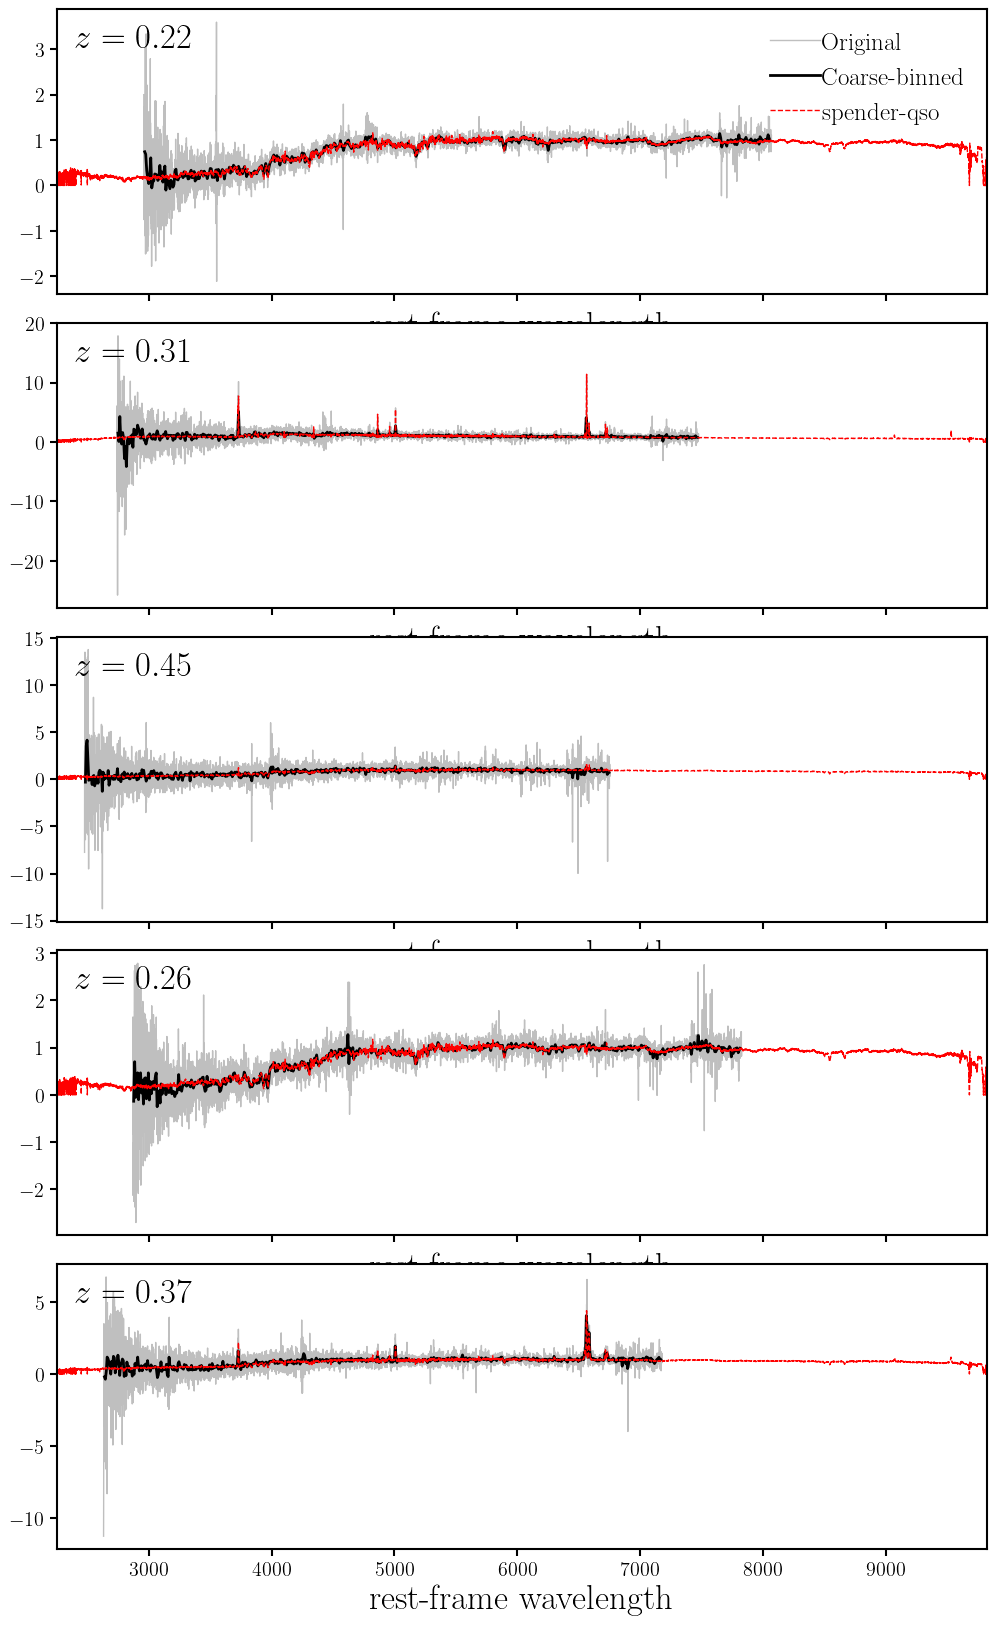

In [14]:
highzs = np.arange(len(z))[-5:]

fig = plt.figure(figsize=(12,4*len(highzs)))

wave_rebin = np.arange(models[0].wave_obs[0], models[0].wave_obs[-1], 10)[1:-1]
for ii, igal in enumerate(highzs):
    sub = fig.add_subplot(len(highzs), 1, ii+1)
    sub.plot(models[0].wave_obs/(1 + z[igal]), spec[igal], c='gray', alpha=0.5, lw=1, label='Original')

    spec_rebin = U.trapz_rebin(np.array(models[0].wave_obs), np.array(spec[igal]), xnew=wave_rebin)
    sub.plot(wave_rebin/(1+z[igal]), spec_rebin, c='k', lw=2, label='Coarse-binned')

    # sub.plot(np.linspace(3.50e3, 1e4, 3251)/(1 + z[igal]), true_cont[igal]/norm[igal], c='C0', lw=2, label='True Continuum')
    sub.plot(models[0].wave_rest, spec_rest[igal], color='r', lw=1, ls='--', label='spender-qso')
    
    
    #sub.axvline(1215.*(1+z[igal]), linestyle='--', color='k')

    sub.text(0.02, 0.95, '$z=%.2f$' % z[igal], ha='left', va='top', fontsize=25, transform=sub.transAxes)

    sub.set_xlim(models[0].wave_rest[0], models[0].wave_rest[-1])
    # sub.set_xlim(6000., 7000.)#models[0].wave_rest[-1])
    if ii < len(highzs)-1: sub.set_xticklabels([])
    if ii == 0: sub.legend(loc='upper right', fontsize=18, handletextpad=0.1)
    sub.set_xlabel("rest-frame wavelength", fontsize=25)
fig.subplots_adjust(hspace=0.1)
plt.show()

In [21]:
highzs

array([], dtype=int64)